## map2loop:  Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of Notebooks 4,5,6 and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [3]:
import os
#print(os.getcwd())
os.chdir('../map2loop')

print(os.getcwd())

from map2loop import m2l_interpolation
from map2loop import m2l_utils


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [4]:
%run -i "../notebooks/m2l_config.py"

this_gcode=('Hamersley Group','Fortescue Group','Turee Group')
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

Default parameters loaded from m2l_config.py:
#ROI
minlong=117 # should back calc from metre system\n",
maxlong=118
minlat=-23
maxlat=-22

step_out=0
inset=0

minx=500057
maxx=603028
miny=7455348
maxy=7567953

#CRS
src_crs = {'init': 'EPSG:4326'}  
dst_crs = {'init': 'EPSG:28350'} 

#PATH
mname='hams3'
geology_file='hams2_geol.shp'
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp'
structure_file='hams2_structure.shp'

test_data_path='../test_data3/'


#CODES
gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'
ncode='NAME'
ocode='OBJECTID'
gicode='GEOPNT_ID'
r1code='ROCKTYPE1'
r2code='ROCKTYPE2'
tcode='TYPE'
fcode='FEATURE'
dscode='DESCRIPTN'
ucode='UNITNAME'
mincode='MIN_AGE_MA'
maxcode='MAX_AGE_MA'
sill_label='sill'
intrusive_label='intrusive'
fold_label='Fold axial trace'

#MODEL_EXTENTS
model_base=-8200


#DECIMATION
orientation_decimate=0
contact_decimate=25
fault_decimate=5
fold_decimate=5


#INTERPOLATION
gridx=100
gridy=100
scheme='scipy_rbf'
dist_buffer=5

#ASSUMPTION

In [6]:
print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import Rbf
from math import sin, cos, atan, atan2, asin, radians, degrees, sqrt, pow, acos
import matplotlib.pyplot as plt

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / (dist)

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def scipy_rbf(x, y, z, xi, yi):
    interp = Rbf(x, y, z, epsilon=1)
    return interp(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)
def excel_call_interpolator(calc,x,y,l,m,n,xi,yi,nx,ny):
    # Calculate IDW or other interpolators

    #display(x)
    #display(y)
    #display(l)
    #display(m)
    #display(xi)
    #display(yi)
    #display(nx)
    #display(ny)
        
    if(calc=='simple_idw'):
        ZIl = simple_idw(x,y,l,xi,yi)
    if(calc=='scipy_rbf'):
        ZIl = scipy_rbf(x,y,l,xi,yi)
    if(calc=='scipy_idw'):
        ZIl = scipy_idw(x,y,l,xi,yi)
#    ZIl = ZIl.reshape((ny-1, nx-1))
    
    if(calc=='simple_idw'):
        ZIm = simple_idw(x,y,m,xi,yi)
    if(calc=='scipy_rbf'):
        ZIm = scipy_rbf(x,y,m,xi,yi)
    if(calc=='scipy_idw'):
        ZIm = scipy_idw(x,y,m,xi,yi)
#    ZIm = ZIm.reshape((ny-1, nx-1))
    
    if(type(n) is not int):
        if(calc=='simple_idw'):
            ZIn = simple_idw(x,y,n,xi,yi)
        if(calc=='scipy_rbf'):
            ZIn = scipy_rbf(x,y,n,xi,yi)
        if(calc=='scipy_idw'):
            ZIn = scipy_idw(x,y,n,xi,yi)
#        ZIn = ZIn.reshape((ny-1, nx-1))   
    else:
        ZIn=0
        
    return(ZIl,ZIm,ZIn)

def excel_interpolate_orientations(structure_file,output_path,bbox,dcode,ddcode,gcode,this_gcode,calc,gridx,gridy):
    print(structure_file,output_path,bbox,dcode,ddcode,gcode,this_gcode,calc,gridx,gridy)
    structure = gpd.read_file(structure_file,bbox=bbox)
    
    if(len(this_gcode)==1):       
        is_gp=structure[gcode] == thisgcode # subset orientations to just those with this group
        gp_structure = structure[is_gp]
    else:
        is_gp=structure[gcode] == this_gcode[0] # subset orientations to just those with this group
        gp_structure = structure[is_gp]
        gp_structure_all = gp_structure.copy()
        
        for i in range (1,len(this_gcode)):
            is_gp=structure[gcode] == this_gcode[i] # subset orientations to just those with this group
            temp_gp_structure = structure[is_gp]
            gp_structure_all = pd.concat([gp_structure_all, temp_gp_structure], ignore_index=True)
    

    npts = len(gp_structure_all)
    
    #nx, ny = gridx,gridy

    #xi = np.linspace(bbox[0],bbox[2], nx-1)
    #yi = np.linspace(bbox[1],bbox[3], ny-1)
    #xi, yi = np.meshgrid(xi, yi)
    #xi, yi = xi.flatten(), yi.flatten()
    
    df = pd.read_csv('../notebooks/filtered_centroid_simple_Top_10.csv')
    display(df)
    xi=  df['X'].to_numpy()
    yi=  df['Y'].to_numpy()
    
    x = np.zeros(npts)
    y = np.zeros(npts)
    dip = np.zeros(npts)
    dipdir = np.zeros(npts)
    
    i=0
    for a_pt in gp_structure_all.iterrows():
        x[i]=a_pt[1]['geometry'].x
        y[i]=a_pt[1]['geometry'].y
        dip[i] = a_pt[1][dcode]
        dipdir[i] = a_pt[1][ddcode]
        i=i+1
    
    l=np.zeros(npts)
    m=np.zeros(npts)
    n=np.zeros(npts)
    
    for i in range(0,npts):
        l[i],m[i],n[i]=m2l_utils.ddd2dircos(dip[i],dipdir[i])

    ZIl,ZIm,ZIn=excel_call_interpolator(calc,x,y,l,m,n,xi,yi,0,0)
    
    # Comparisons...
 #   plot(x,y,l,ZIl)
 #   plt.title('l')
 #   plot(x,y,m,ZIm)
 #   plt.title('m')
 #   plot(x,y,n,ZIn)
 #   plt.title('n')
    
 #   plt.show()
    
    f=open(output_path+'xls_input.csv','w')
    fi=open(output_path+'xls_interpolation_'+calc+'.csv','w')
    fl=open(output_path+'xls_interpolation_l.csv','w')
    fm=open(output_path+'xls_interpolation_m.csv','w')
    fn=open(output_path+'xls_interpolation_n.csv','w')
    
    f.write("x,y,dip,dipdirection\n")
    fi.write("x,y,dip,dipdirection\n")
    fl.write("x,y,l\n")
    fm.write("x,y,m\n")
    fn.write("x,y,n\n")
    
    for i in range (0,npts):
        ostr=str(x[i])+","+str(y[i])+","+str(int(dip[i]))+","+str(int(dipdir[i]))+'\n'
        f.write(ostr)
    
#    for xx in range (0,gridx-1):
#        for yy in range (0,gridy-1):
    for i in range (0,len(xi)):
            L=ZIl[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            M=ZIm[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            N=ZIn[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            
            dip,dipdir=m2l_utils.dircos2ddd(L,M,N)

            ostr=str(xi[i])+","+str(yi[i])+","+str(int(dip))+","+str(int(dipdir))+'\n'
            fi.write(ostr)
            
            ostr=str(xi[i])+","+str(yi[i])+","+str(L)+'\n'
            fl.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(M)+'\n'
            fm.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(N)+'\n'
            fn.write(ostr)
            print(xi[i],yi[i],ZIl[i],ZIm[i],ZIn[i],dip,dipdir,sep='\t')
    
    f.close()
    fi.close()
    fl.close()
    fm.close()
    fn.close()
    
    fig, ax = plt.subplots(figsize=(10, 10),)
    q = ax.quiver(xi, yi, -ZIm, ZIl,headwidth=0)
    plt.show()
    print("orientations interpolated as dip dip direction",output_path+'interpolation_'+calc+'.csv')
    print("orientations interpolated as l,m,n dir cos",output_path+'interpolation_l.csv etc.')

../test_data3/tmp/structure_clip.shp ../test_data3/tmp/ (500057, 7455348, 603028, 7567953) DIP DIP_DIR GROUP_ ('Hamersley Group', 'Fortescue Group', 'Turee Group') scipy_rbf 0 0


,X,Y,area
0,504191.199226,7.501737e+06,1.183026e+08
1,558316.771064,7.474441e+06,2.176815e+08
2,557867.825212,7.525695e+06,1.794358e+08
3,565299.101325,7.518819e+06,1.557316e+08
4,541309.305372,7.542409e+06,1.358698e+08
5,565765.068438,7.551797e+06,1.325847e+08
6,549180.856762,7.550381e+06,1.790615e+08
7,577772.857205,7.538050e+06,1.402332e+08
8,577464.113684,7.523463e+06,2.049057e+08
9,585286.247362,7.515451e+06,2.554154e+08


504191.19922615896	7501736.70303492	-0.20646296094089678	-0.18285914743768217	0.8210338317650212	18.567985616873344	228.46948062364356
558316.771064376	7474440.86486117	0.10142935927166263	0.19106486372044174	0.875920292399357	13.872269250924944	27.96220032133772
557867.825211725	7525695.46708792	0.007423686348275282	0.0037267880182696445	0.9654281648182668	0.4929657088531201	63.34274807498309
565299.101325419	7518819.29005526	-0.10437388777407364	-0.07094992739712325	0.9751725349387357	7.374147295768623	235.79342656767153
541309.30537202	7542409.07570252	0.20084725192288033	0.2555449891288504	0.9320410987017489	19.22501965409957	38.16580713322628
565765.068438033	7551796.69525574	0.030759364378766918	-0.009919998472440739	0.9612120424168396	1.9257654706455725	107.87468592816202
549180.856762149	7550380.78642382	0.12963183403833511	0.18363564647444264	0.9709641155339561	13.034516270640125	35.218982321016256
577772.857204925	7538049.74171396	0.02338017519616642	0.06259075393222702	0.950

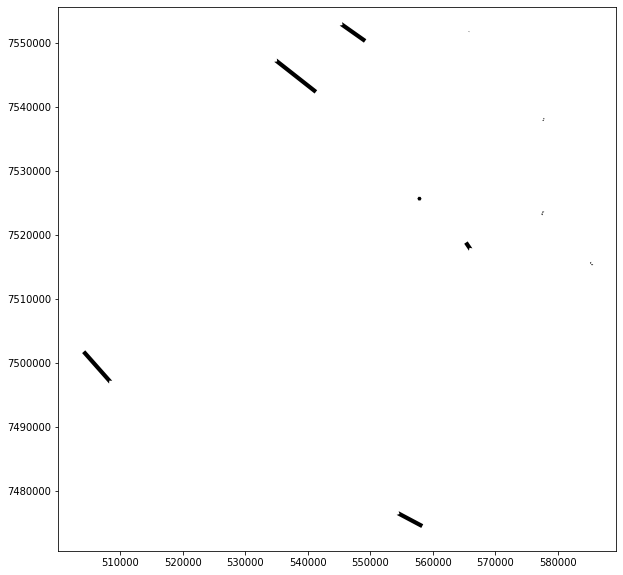

orientations interpolated as dip dip direction ../test_data3/tmp/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data3/tmp/interpolation_l.csv etc.


In [8]:
excel_interpolate_orientations(structure_file,tmp_path,bbox,dcode,ddcode,gcode,this_gcode,scheme,0,0)

In [11]:
def excel_interpolate_contacts(geology_file,output_path,dtm,bbox,dcode,ddcode,gcode,ccode,calc,gridx,gridy):
    print(geology_file,output_path,bbox,dcode,ddcode,gcode,calc,gridx,gridy)
    geol_file = gpd.read_file(geology_file,bbox=bbox)
    print(len(geol_file))
    #geol_file.plot( color='black',edgecolor='black') 
    
    # Setup: Generate data...
    npts = 0
    decimate=2
    nx, ny = gridx,gridy

    #xi = np.linspace(bbox[0],bbox[2], nx-1)
    #yi = np.linspace(bbox[1],bbox[3], ny-1)
    #xi, yi = np.meshgrid(xi, yi)
    #xi, yi = xi.flatten(), yi.flatten()
    
    df = pd.read_csv('../notebooks/filtered_centroid_simple_Top_10.csv')
    display(df)
    xi=  df['X'].to_numpy()
    yi=  df['Y'].to_numpy()
    
    x = np.zeros(20000)
    y = np.zeros(20000)
    l = np.zeros(20000)
    m = np.zeros(20000)
    f=open(output_path+'xls_raw_contacts.csv','w')
    f.write("X,Y,Z,angle,lsx,lsy,formation,group\n")
    j=0
    i=0
    for acontact in geol_file.iterrows():   #loop through distinct linestrings in MultiLineString
        if(acontact[1].geometry.type=='MultiLineString'):
            #print(i)
            for line in acontact[1].geometry: # loop through line segments
                #print(i,len(acontact[1].geometry))
                if(m2l_utils.mod_safe(i,decimate)  ==0):
                    #if(acontact[1]['id']==170): 
                        #display(npts,line.coords[0][0],line.coords[1][0]) 
                    dlsx=line.coords[0][0]-line.coords[1][0]
                    dlsy=line.coords[0][1]-line.coords[1][1]
                    if(not line.coords[0][0]==line.coords[1][0] or not line.coords[0][1]==line.coords[1][1]):               
                        lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        x[i]=line.coords[1][0]+(dlsx/2)
                        y[i]=line.coords[1][1]+(dlsy/2)
                        angle=degrees(atan2(lsx,lsy))
                        l[i]=lsx
                        m[i]=lsy
                        locations=[(x[i],y[i])] #doesn't like point right on edge?
                        height=m2l_utils.value_from_raster(dtm,locations)
                        if(str(acontact[1][gcode])=='None'):
                            ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][ccode].replace(" ","_").replace("-","_")+","+acontact[1][ccode].replace(" ","_").replace("-","_")+"\n"
                        else:
                            ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][ccode].replace(" ","_").replace("-","_")+","+acontact[1][gcode].replace(" ","_").replace("-","_")+"\n"
                        f.write(ostr)
                        npts=npts+1
                i=i+1
        else:
            #display(acontact[1].geometry,acontact[1].geometry.coords)
            #for line in acontact[1]: # loop through line segments in LineString
            #print(acontact[1].geometry.type)
            if(  m2l_utils.mod_safe(i,decimate)  ==0):
                dlsx=acontact[1].geometry.coords[0][0]-acontact[1].geometry.coords[1][0]
                dlsy=acontact[1].geometry.coords[0][1]-acontact[1].geometry.coords[1][1]
                if(not acontact[1].geometry.coords[0][0]==acontact[1].geometry.coords[1][0] 
                   or not acontact[1].geometry.coords[0][1]==acontact[1].geometry.coords[1][1]):
                    lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    x[i]=acontact[1].geometry.coords[1][0]+(dlsx/2)
                    y[i]=acontact[1].geometry.coords[1][1]+(dlsy/2)
                    angle=degrees(atan2(lsx,lsy))
                    l[i]=lsx
                    m[i]=lsy
                    locations=[(x[i],y[i])] #doesn't like point right on edge?
                    height=m2l_utils.value_from_raster(dtm,locations)
                    if(str(acontact[1][gcode])=='None'):
                        ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][ccode].replace(" ","_").replace("-","_")+","+acontact[1][ccode].replace(" ","_").replace("-","_")+"\n"
                    else:
                        ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][ccode].replace(" ","_").replace("-","_")+","+acontact[1][gcode].replace(" ","_").replace("-","_")+"\n"
                    #ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+"\n"
                    #print(ostr)
                    f.write(ostr)
                    #print(npts,dlsx,dlsy)
                    npts=npts+1
                i=i+1
        j=j+1
    f.close()
    
    #print("i",i,"npts",npts)
    for i in range(0,npts):
        x[i]=x[i]+(np.random.ranf()*0.01)
        y[i]=y[i]+(np.random.ranf()*0.01)

    ZIl,ZIm,ZIn=excel_call_interpolator(calc,x[:npts],y[:npts],l[:npts],m[:npts],0,xi,yi,0,0)    
    
    # Comparisons...
    #plot(x,y,l,ZIl)
    #plt.title('l')
    #plot(x,y,m,ZIm)
    #plt.title('m')

    fi=open(output_path+'xls_interpolation_contacts_'+calc+'.csv','w')
    fl=open(output_path+'xls_interpolation_contacts_l.csv','w')
    fm=open(output_path+'xls_interpolation_contacts_m.csv','w')
    
    fi.write("x,y,angle\n")
    fl.write("x,y,l\n")
    fm.write("x,y,m\n")
    
#    for xx in range (0,gridx-1):
#        for yy in range (0,gridy-1):
    for i in range (0,len(xi)):
            #yyy=xx
            #xxx=gridy-2-yy
            L=ZIl[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))))
            M=ZIm[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))))
            S=degrees(atan2(L,M))
            ostr=str(xi[i])+","+str(yi[i])+","+str(int(S))+'\n'

            fi.write(ostr)
            
            ostr=str(xi[i])+","+str(yi[i])+","+str(L)+'\n'
            fl.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(M)+'\n'
            fm.write(ostr)
            print("out",xi[i],yi[i],ZIl[i],ZIm[i],S,sep='\t')
    fi.close()
    fl.close()
    fm.close()
    fig, ax = plt.subplots(figsize=(10, 10))
    display(ZIl,ZIm)
    q = ax.quiver(xi, yi, ZIl, ZIm,headwidth=0)
    plt.show()
    print("contacts interpolated as strike",output_path+'xls_interpolation_contacts_'+calc+'.csv')
    print("contacts interpolated as l,m dir cos",output_path+'xls_interpolation_contacts_l.csv etc.')


../test_data3/tmp/basal_contacts2.shp ../test_data3/tmp/ (500057, 7455348, 603028, 7567953) DIP DIP_DIR GROUP_ scipy_rbf 0 0
176


,X,Y,area
0,504191.199226,7.501737e+06,1.183026e+08
1,558316.771064,7.474441e+06,2.176815e+08
2,557867.825212,7.525695e+06,1.794358e+08
3,565299.101325,7.518819e+06,1.557316e+08
4,541309.305372,7.542409e+06,1.358698e+08
5,565765.068438,7.551797e+06,1.325847e+08
6,549180.856762,7.550381e+06,1.790615e+08
7,577772.857205,7.538050e+06,1.402332e+08
8,577464.113684,7.523463e+06,2.049057e+08
9,585286.247362,7.515451e+06,2.554154e+08


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=8.44193e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


out	504191.19922615896	7501736.70303492	0.9044189453125	-0.005706787109375	90.36152546148129
out	558316.771064376	7474440.86486117	0.0936279296875	-1.06988525390625	174.99866609722432
out	557867.825211725	7525695.46708792	0.2247314453125	-0.215911865234375	133.85336452330137
out	565299.101325419	7518819.29005526	0.558837890625	0.939239501953125	30.752212457126884
out	541309.30537202	7542409.07570252	1.648193359375	-0.695587158203125	112.88120721380389
out	565765.068438033	7551796.69525574	0.997314453125	-0.8299560546875	129.766920689735
out	549180.856762149	7550380.78642382	1.3765869140625	-1.046630859375	127.24603988393778
out	577772.857204925	7538049.74171396	1.0355224609375	0.16448974609375	80.97414177730445
out	577464.11368406	7523462.82580886	0.81640625	-0.4658203125	119.70796391834422
out	585286.247361515	7515450.62987171	0.0826416015625	-1.20318603515625	176.07077401450113


array([0.90441895, 0.09362793, 0.22473145, 0.55883789, 1.64819336,
       0.99731445, 1.37658691, 1.03552246, 0.81640625, 0.0826416 ])

array([-0.00570679, -1.06988525, -0.21591187,  0.9392395 , -0.69558716,
       -0.82995605, -1.04663086,  0.16448975, -0.46582031, -1.20318604])

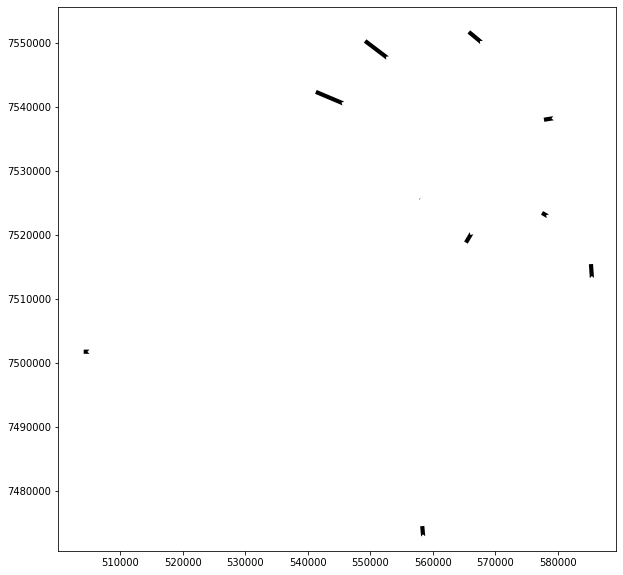

contacts interpolated as strike ../test_data3/tmp/xls_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data3/tmp/xls_interpolation_contacts_l.csv etc.


In [12]:
import rasterio

bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

dtm = rasterio.open(dtm_reproj_file)
geology_file=tmp_path+'basal_contacts2.shp'

excel_interpolate_contacts(geology_file,tmp_path,dtm,bbox,dcode,ddcode,gcode,ccode,scheme,0,0)


In [13]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

lc=np.loadtxt(tmp_path+'xls_interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'xls_interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'xls_interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'xls_interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'xls_interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'xls_interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)


In [18]:
from shapely.geometry import Point
from geopandas import GeoDataFrame

def excel_join_contacts_and_orientations(combo_file,geology_file,output_path,dtm_reproj_file,ccode,lo,mo,no,lc,mc,xy,dst_crs,bbox):
    f=open(combo_file,'w')
    f.write('x,y,dip,dipdirection,misorientation,dotproduct\n')

    for i in range(0,len(lc)):
        scale=sqrt(1-pow(no[i,2],2)) #scaling contact dircos to *include* dip info
        lcscaled=scale*-mc[i,2] #includes 90 rotation to account for orthogonality of contact and dip direction
        mcscaled=scale*lc[i,2]
        scale2=sqrt(pow(lo[i,2],2)+pow(mo[i,2],2)) #scaling dip dipdir dircos to *exclude* dip info
        loscaled=lo[i,2]/scale2
        moscaled=mo[i,2]/scale2
        dotproduct=(-mc[i,2]*loscaled)+(lc[i,2]*moscaled) #includes 90 rotation to account for orthogonality of contact and dip direction
        if(dotproduct<0):
            lcscaled=-lcscaled
            mcscaled=-mcscaled
        misorientation=degrees(acos(dotproduct))
        dip,dipdir=m2l_utils.dircos2ddd(lcscaled,mcscaled,no[i,2])
        ostr=str(xy[i,0])+','+str(xy[i,1])+','+str(int(dip))+','+str(int(dipdir))+','+str(int(misorientation))+','+str(dotproduct)+'\n'
        f.write(ostr)
    f.close()   
    
    
    geology = gpd.read_file(geology_file,bbox=bbox)
    geology.crs=dst_crs
    geology = m2l_utils.explode(geology)
    
    data = pd.read_csv(combo_file)
    
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]
        
    gdf = GeoDataFrame(data, crs=dst_crs, geometry=geometry)
    
    gdf.crs=dst_crs
    print(gdf.crs,geology.crs)    
    structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
    dtm = rasterio.open(dtm_reproj_file)
    f=open(output_path+'xls_combo_full.csv','w')
    f.write('X,Y,Z,azimuth,dip,polarity,formation\n')
    for a_point in structure_code.iterrows():
        locations=[(a_point[1]['x'],a_point[1]['y'])]
        height=m2l_utils.value_from_raster(dtm,locations)
        ostr=str(a_point[1]['x'])+','
        ostr=ostr+str(a_point[1]['y'])+','
        ostr=ostr+str(height)+','+str(int(a_point[1]['dipdirection']))+','
        ostr=ostr+str(int(a_point[1]['dip']))+',1,'
        ostr=ostr+str(a_point[1][ccode]).replace("-","_")+'\n'

        if(not str(a_point[1][ccode])=='nan'):
            f.write(ostr)
    f.close()  
    print("contacts and orientations interpolated as dip dip direction",output_path+'xls_combo_full.csv')
 

In [19]:
excel_join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,ccode,lo,mo,no,lc,mc,xy,dst_crs,bbox)


{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data3/tmp/xls_combo_full.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')
